In [1]:
from TCFile import TCFile

In [2]:
import os
import torch
from torchvision import models
import numpy as np
import utils
from tqdm import tqdm

In [22]:
path = r"C:\rkka_Projects\cell_death_v2\Data\1_Ligand\0510_rest\230510.HeLa_TNF (10).TCF"
file = TCFile(path, '2DMIP')
crop_size = (160, 160)
necrosis = False

result_stack = {}
# for time in range(len(file)):
for time in tqdm(range(32)):
    # Match resolution
    slice_2d = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution,
                                                    target_resolution=0.1632, mode='mip')
    
    # Crop
    patches = utils.crop_patch(slice_2d, crop_size=crop_size)

    cropped_dict = {}
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
        cropped[cropped<1.33] = 1.33
        cropped[cropped>1.40] = 1.40
        cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
        
        cropped_dict[f'patch_{patch_index}'] = cropped
    
    # Load Model
    model = models.resnet101(pretrained=True)
    num_features = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(num_features, 5)
    )
    model.load_state_dict(torch.load('test_5_classes_0.9603.pth'))
    
    # Evaluation
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
    results = {}
    result_number = []
    
    model = model.cuda()
    model.eval()
    with torch.no_grad():
        for patch in list(cropped_dict.keys()):
            image_array = cropped_dict[patch]
            
            if necrosis==False:
                temp = image_array.copy()
                temp[temp<45] = 0
                temp[temp>45] = 1
                proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
                if proportion < 0.05:
                    pass
                    # results[patch] = 0
                else:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    image_tensor = image_tensor.cuda()
                    output = model(image_tensor.unsqueeze(0))
                    output = output.cpu()
                    _, pred = torch.max(output, 1)
                    results[patch] = pred.item()
                    
            elif necrosis==True:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                image_tensor = image_tensor.cuda()
                
                output = model(image_tensor.unsqueeze(0))
                output = output.cpu()
                _, pred = torch.max(output, 1)
                results[patch] = pred.item()
    
    for i in range(5):
        r = np.array(list(results.values()))
        result_number.append(np.sum(r==i)/len(r))
    
    result_stack['time_'+str(time).zfill(2)] = result_number
        

  0%|          | 0/32 [00:00<?, ?it/s]c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_22268\587318665.py:34: FutureWarni

In [18]:
os.path.basename(path)[:-4]

'240808.200653.death_B4C4B5.005.Group2.C4.T001P01'

In [19]:
import json

# Convert and write JSON object to file
with open(f"{os.path.basename(path)[:-4]}.json", "w") as outfile: 
    json.dump(result_stack, outfile)
    outfile.close()

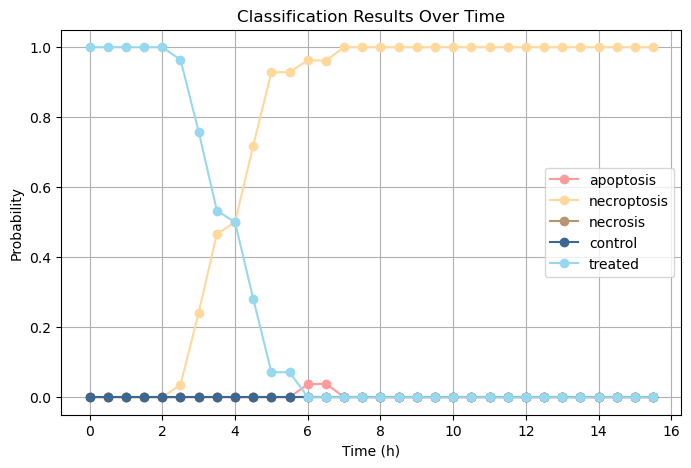

In [38]:
import matplotlib.pyplot as plt

# Extract time steps and convert to sorted list
time_steps = sorted(result_stack.keys())
time_steps_axis = [i/2 for i in range(len(time_steps))]

# Transpose data to get class-wise values
num_classes = len(result_stack[time_steps[0]])
class_values = {f'Class_{i}': [] for i in range(num_classes)}

# Define custom colors
colors = ["#FF9B9B", "#FFD89C", "#B99470", '#3B6790', "#98D8EF"]

for time in time_steps:
    for i, value in enumerate(result_stack[time]):
        class_values[f'Class_{i}'].append(value)

# Plotting
plt.figure(figsize=(8, 5))

classes = ['apoptosis', 'necroptosis', 'necrosis', 'control', 'treated']
for idx, values in enumerate(list(class_values.values())):
    plt.plot(time_steps_axis, values, marker='o', linestyle='-', label=classes[idx], c=colors[idx])

plt.xlabel("Time (h)")
plt.ylabel("Probability")
plt.title("Classification Results Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
import json
with open("0510_ligand_results/230510.HeLa_CD95 (16).TCF.json", "r") as f:
    result_stack = json.load(f)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_22268\3552768895.py:37: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\miniconda3\envs\cell\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12599 (\N{HANGUL LETTER TIKEUT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


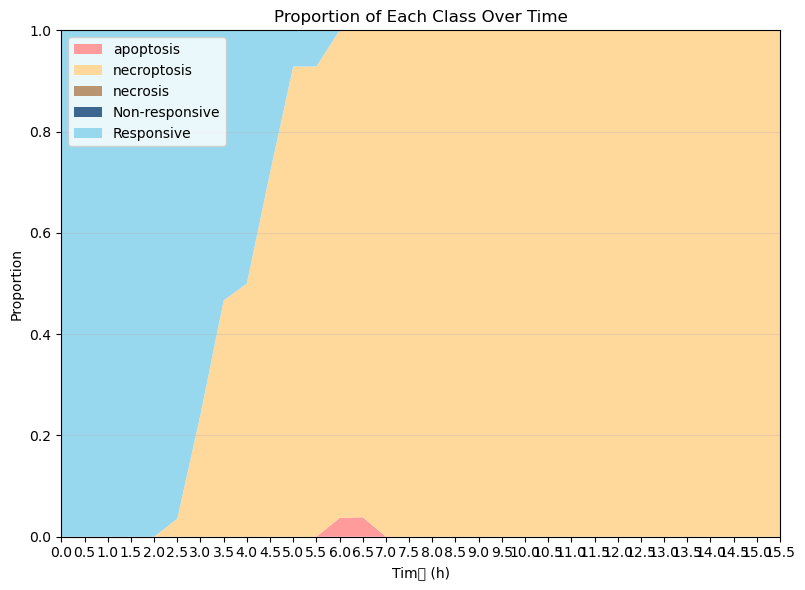

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Class names
classes = ['apoptosis', 'necroptosis', 'necrosis', 'Non-responsive', 'Responsive']
# Define custom colors
colors = ["#FF9B9B", "#FFD89C", "#B99470", '#3B6790', "#98D8EF"]

# Sort time steps (if needed)
time_steps = sorted(result_stack.keys())
time_steps_axis = [i/2 for i in range(len(time_steps))]

# Convert to NumPy array: shape -> (#classes, #time_steps)
# Transpose so each row is a class, each column is a time step
data = np.array([result_stack[t] for t in time_steps]).T

# Compute proportions so each column sums to 1
column_sums = data.sum(axis=0, keepdims=True)
data_prop = data / column_sums  # shape still (#classes, #time_steps)

# We'll use numeric x-values for plotting
x_positions = np.arange(len(time_steps))

plt.figure(figsize=(8, 6))

# Create the stacked area plot
plt.stackplot(x_positions, data_prop, labels=classes, colors=colors)

# Tidy up axes and labels
plt.xticks(x_positions, time_steps_axis)
plt.ylim(0, 1)
plt.xlabel("Timㄷ (h)")
plt.ylabel("Proportion")
plt.title("Proportion of Each Class Over Time")
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.xlim(0, 31)
plt.show()


In [42]:
sum(list(result_stack.values())[0])

36

In [41]:
def process(path):
    path = path
    file = TCFile(path, '2DMIP')
    crop_size = (160, 160)
    necrosis = False
    
    # Load Model
    model = models.resnet101(pretrained=True)
    num_features = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.2),
        torch.nn.Linear(num_features, 5)
    )
    model.load_state_dict(torch.load('test_5_classes_0.9603.pth'))

    result_stack = {}
    # for time in range(len(file)):
    for time in range(33):
        # Match resolution
        slice_2d = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution,
                                                        target_resolution=0.1632, mode='mip')
        
        # Crop
        patches = utils.crop_patch(slice_2d, crop_size=crop_size)

        cropped_dict = {}
        for patch_index, patch in enumerate(patches):
            top = patch[0]
            left = patch[1]
            cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
            cropped[cropped<1.33] = 1.33
            cropped[cropped>1.40] = 1.40
            cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
            
            cropped_dict[f'patch_{patch_index}'] = cropped
        
        # Evaluation
        transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
        results = {}
        result_number = []
        
        model = model.cuda()
        model.eval()
        with torch.no_grad():
            for patch in list(cropped_dict.keys()):
                image_array = cropped_dict[patch]
                
                if necrosis==False:
                    temp = image_array.copy()
                    temp[temp<45] = 0
                    temp[temp>45] = 1
                    proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
                    if proportion < 0.05:
                        pass
                        # results[patch] = 0
                    else:
                        image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                        image_tensor = transform(image_tensor)
                        image_tensor = image_tensor.cuda()
                        output = model(image_tensor.unsqueeze(0))
                        output = output.cpu()
                        _, pred = torch.max(output, 1)
                        results[patch] = pred.item()
                        
                elif necrosis==True:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    image_tensor = image_tensor.cuda()
                    
                    output = model(image_tensor.unsqueeze(0))
                    output = output.cpu()
                    _, pred = torch.max(output, 1)
                    results[patch] = pred.item()
        
        for i in range(5):
            r = np.array(list(results.values()))
            result_number.append(np.sum(r==i)/len(r))
        
        result_stack['time_'+str(time).zfill(2)] = result_number
        
    return result_stack

In [57]:
import os
from tqdm import tqdm
import json

root_dir = r"C:\rkka_Projects\cell_death_v2\Data\1_Ligand\0512"
file_list = os.listdir(root_dir)
total_results = {}
for file in tqdm(file_list):
    result = process(os.path.join(root_dir, file))
    total_results[file] = result
    # Convert and write JSON object to file
    with open(f"C:/rkka_Projects/cell_death_v2/0512_ligand_results/{file}.json", "w") as outfile: 
        json.dump(result, outfile)
        outfile.close()

  0%|          | 0/70 [00:00<?, ?it/s]c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_22268\2970613502.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github

<h1> Drug induction analysis </h1>

Mean values: [0.76218194 0.23176216 0.         0.00178571 0.00427019]
Std values: [0.2107984  0.20747482 0.         0.01041241 0.01759016]


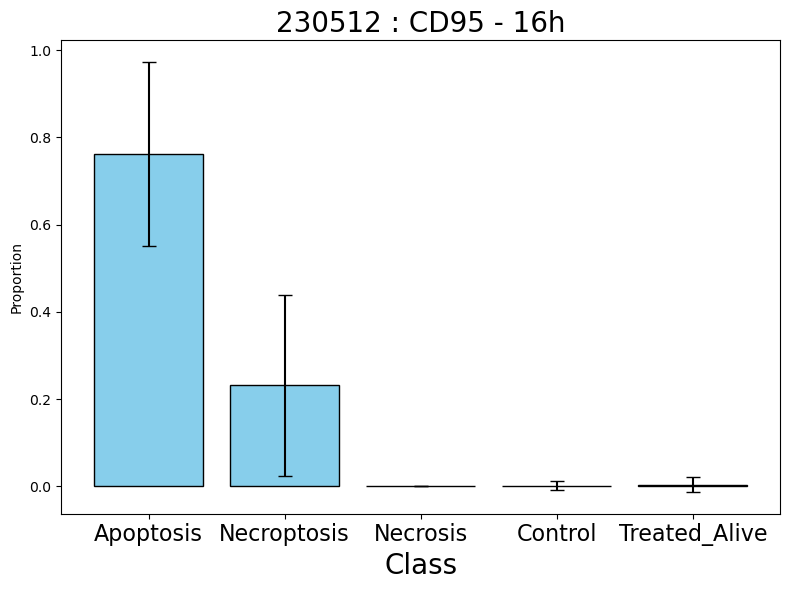

In [113]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

drug = 'CD95'
date = '230512'
results = []
root_dir = r"C:\rkka_Projects\cell_death_v2\0512_ligand_results"

# Iterate over all JSON files in the directory
for file in os.listdir(root_dir):
    if file.endswith('.json'):
        if drug in file:
            file_path = os.path.join(root_dir, file)
            with open(file_path, "r") as f:
                data = json.load(f)
            if "time_32" in data:
                results.append(data["time_32"])
            else:
                print(f"'time_32' not found in {file}")

# Convert the list of lists to a NumPy array
# Each row corresponds to a file and each column to a class proportion (a, b, c, d, e)
results_array = np.array(results)

# Compute mean and standard deviation along the files (axis 0)
mean_vals = np.mean(results_array, axis=0)
std_vals = np.std(results_array, axis=0)

print("Mean values:", mean_vals)
print("Std values:", std_vals)

# Plotting the means with error bars for the standard deviations
classes = ['Apoptosis', 'Necroptosis', 'Necrosis', 'Control', 'Treated_Alive']
x = np.arange(len(classes))

plt.figure(figsize=(8, 6))
plt.bar(x, mean_vals, yerr=std_vals, capsize=5, color='skyblue', edgecolor='black')
plt.xticks(x, classes, fontsize=16)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Proportion')
plt.title(f'{date} : {drug} - 16h', fontsize=20)
plt.tight_layout()
plt.show()


C:\Users\김민욱\AppData\Local\Temp\ipykernel_22268\2520914661.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Class', y='Proportion', data=df_melted, inner=None, palette=custom_palette)


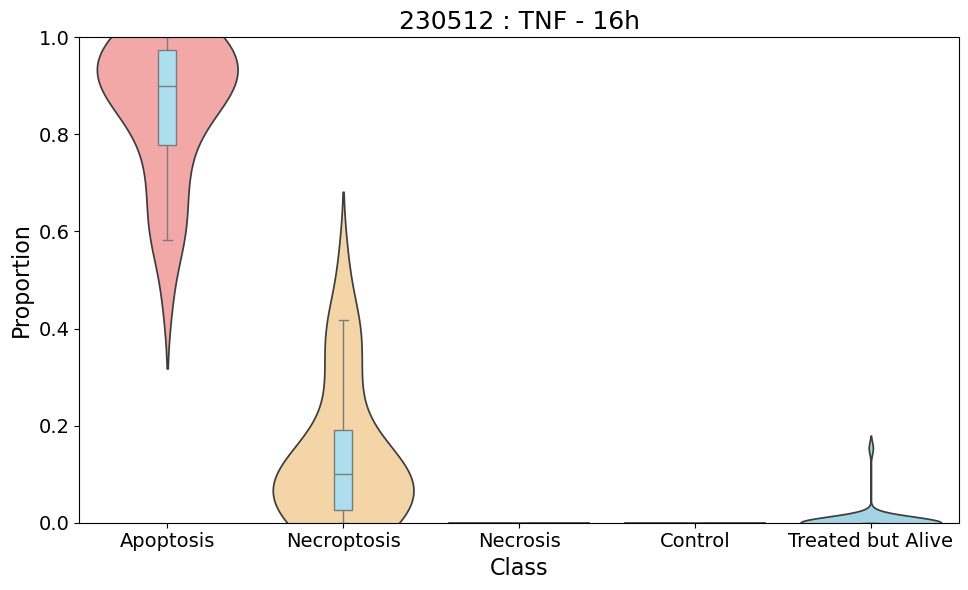

In [112]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

drug = 'TNF'
date = '230512'
results = []
root_dir = r"C:\rkka_Projects\cell_death_v2\0512_ligand_results"

# Iterate over JSON files for the specified drug
for file in os.listdir(root_dir):
    if file.endswith('.json') and drug in file:
        file_path = os.path.join(root_dir, file)
        with open(file_path, "r") as f:
            data = json.load(f)
        if "time_32" in data:
            results.append(data["time_32"])
        else:
            print(f"'time_32' not found in {file}")

results_array = np.array(results)
classes = ['Apoptosis', 'Necroptosis', 'Necrosis', 'Control', 'Treated but Alive']

# Prepare the DataFrame in long format for Seaborn
df = pd.DataFrame(results_array, columns=classes)
df_melted = df.melt(var_name='Class', value_name='Proportion')

plt.figure(figsize=(10, 6))

# Define custom color palette mapping for each class
custom_palette = {
    'Apoptosis': '#FF9B9B',         
    'Necroptosis': '#FFD89C',       
    'Necrosis': '#B99470',           
    'Control': '#3B6790',            
    'Treated but Alive': '#98D8EF'   
}
# Plot the violin plot without inner box
ax = sns.violinplot(x='Class', y='Proportion', data=df_melted, inner=None, palette=custom_palette)

# Overlay a custom box plot with your desired box width
sns.boxplot(x='Class', y='Proportion', data=df_melted,
            width=0.1,  # adjust this value to control the box width
            fliersize=0,  # hide outliers if you prefer
            boxprops={'linewidth': 1},  # increase the line width
            ax=ax,
            color='#A1E3F9')

plt.title(f'{date} : {drug} - 16h', fontsize=18)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.ylim(0,1)

plt.show()
